*Use this notebook to complete the sentence similarity and embedding visualization tasks.*


In [2]:
import pickle
import numpy as np
from numpy.linalg import norm

def load_pytorch_pickle(path="word2vec_embeddings.pkl"):
    with open(path, "rb") as f:
        d = pickle.load(f)
    emb = d["embeddings"]
    if hasattr(emb, "detach"):
        emb = emb.detach().cpu().numpy()
    emb = np.asarray(emb)
    return {"emb": emb, "word2idx": d["word2idx"], "idx2word": d["idx2word"], "dim": emb.shape[1]}

def load_gensim_pickle(path="word2vec_gensim_embeddings.pkl"):
    with open(path, "rb") as f:
        d = pickle.load(f)
    emb = d["embeddings"]
    if hasattr(emb, "detach"):
        emb = emb.detach().cpu().numpy()
    emb = np.asarray(emb)
    return {"emb": emb, "word2idx": d["word2idx"], "idx2word": d["idx2word"], "dim": emb.shape[1]}

pytorch_src = load_pytorch_pickle("word2vec_embeddings.pkl")
gensim_text8_src = load_gensim_pickle("word2vec_gensim_embeddings.pkl")


In [3]:
import gensim

w2v_google = gensim.models.KeyedVectors.load("word2vec-google-news-300.model")
ft_wiki = gensim.models.KeyedVectors.load("fasttext-wiki-news-subwords-300.model")

pretrained_w2v_src = {"kv": w2v_google, "dim": w2v_google.vector_size}
pretrained_ft_src = {"kv": ft_wiki, "dim": ft_wiki.vector_size}


In [4]:
def get_vec_pytorch(src, token):
    i = src["word2idx"].get(token, None)
    if i is None:
        return None
    return src["emb"][i]

def get_vec_gensim_text8(src, token):
    i = src["word2idx"].get(token, None)
    if i is None:
        return None
    return src["emb"][i]

def get_vec_kv(src, token):
    kv = src["kv"]
    if token in kv:
        return kv[token]
    return None

def sent_embedding(tokens, vec_getter):
    vecs = [vec_getter(t) for t in tokens]
    vecs = [v for v in vecs if v is not None]
    if len(vecs) == 0:
        return None
    return np.mean(np.stack(vecs, axis=0), axis=0)

def cosine_sim(a, b, eps=1e-12):
    if a is None or b is None:
        return None
    na = norm(a)
    nb = norm(b)
    if na < eps or nb < eps:
        return None
    return float(np.dot(a, b) / (na * nb))

def evaluate_sentence_similarity(query, sentences, tokenizer, sources):
    q_toks = tokenizer(query)
    out = {}
    for name, vec_getter in sources.items():
        q_emb = sent_embedding(q_toks, vec_getter)
        sims = []
        for s in sentences:
            s_emb = sent_embedding(tokenizer(s), vec_getter)
            sims.append(cosine_sim(q_emb, s_emb))
        out[name] = sims
    return out


In [5]:
!pip install nltk


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [6]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")

from nltk.tokenize import word_tokenize

def tokenize_text(text):
    return word_tokenize(text.lower())


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jeffreyzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jeffreyzhang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
sentences = [
    "The cat sat on the mat.",
    "A dog is playing in the yard.",
    "I need to buy groceries today.",
    "The feline was resting on the rug.",
    "Canines enjoy outdoor activities.",
    "My shopping list includes milk and bread.",
    "The weather is beautiful today.",
    "Programming requires logical thinking."
]

query = "My pet cat is sleeping on the carpet."


In [8]:
sources = {
    "PyTorch_SGNS_100": lambda t: get_vec_pytorch(pytorch_src, t),
    "Gensim_Text8_100": lambda t: get_vec_gensim_text8(gensim_text8_src, t),
    "Pretrained_W2V_300": lambda t: get_vec_kv(pretrained_w2v_src, t),
    "Pretrained_FastText_300": lambda t: get_vec_kv(pretrained_ft_src, t),
}

results = evaluate_sentence_similarity(query, sentences, tokenize_text, sources)


In [9]:
for name, sims in results.items():
    print(name)
    for s, sim in zip(sentences, sims):
        print(f"{sim if sim is not None else 'NA':>8}  {s}")
    print()


PyTorch_SGNS_100
0.5686519742012024  The cat sat on the mat.
0.259709894657135  A dog is playing in the yard.
0.09829361736774445  I need to buy groceries today.
0.411150187253952  The feline was resting on the rug.
0.1427692025899887  Canines enjoy outdoor activities.
0.03466248884797096  My shopping list includes milk and bread.
0.37099239230155945  The weather is beautiful today.
0.001531337620690465  Programming requires logical thinking.

Gensim_Text8_100
0.7174028158187866  The cat sat on the mat.
0.6062320470809937  A dog is playing in the yard.
0.18702319264411926  I need to buy groceries today.
0.5073262453079224  The feline was resting on the rug.
0.09180303663015366  Canines enjoy outdoor activities.
0.4669860303401947  My shopping list includes milk and bread.
0.5028771162033081  The weather is beautiful today.
0.09241566807031631  Programming requires logical thinking.

Pretrained_W2V_300
0.736871600151062  The cat sat on the mat.
0.6482781171798706  A dog is playing in th

In [10]:
animals = [
    'dog', 'cat', 'horse', 'cow',
    'lion', 'tiger', 'elephant', 'giraffe',
    'eagle', 'hawk', 'sparrow', 'penguin',
    'shark', 'whale', 'dolphin', 'tuna'
]

foods = [
    'apple', 'orange', 'banana', 'grape',
    'bread', 'pasta', 'rice', 'potato',
    'chicken', 'beef', 'pork', 'fish',
    'coffee', 'tea', 'juice', 'water'
]


In [11]:
def collect_vectors(words_by_group, vec_getter):
    X, labels, groups = [], [], []
    for group_name, words in words_by_group.items():
        for w in words:
            v = vec_getter(w)
            if v is None:
                continue
            X.append(v)
            labels.append(w)
            groups.append(group_name)
    if len(X) == 0:
        return None, None, None
    return np.stack(X, axis=0), labels, groups

words_by_group = {"animals": animals, "foods": foods}


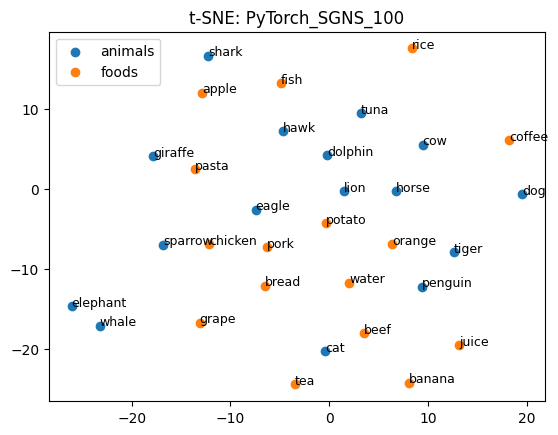

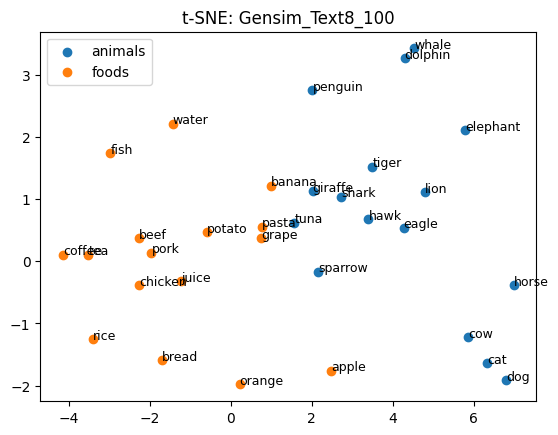

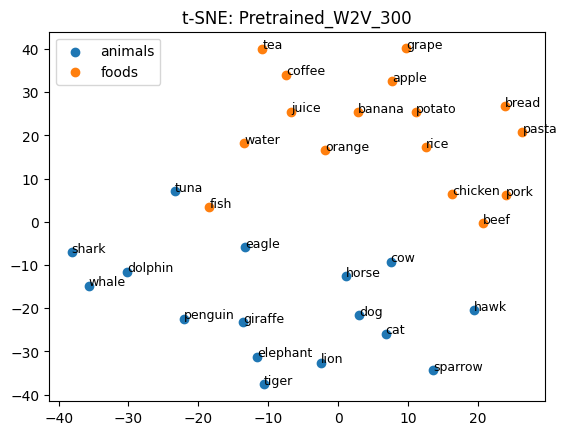

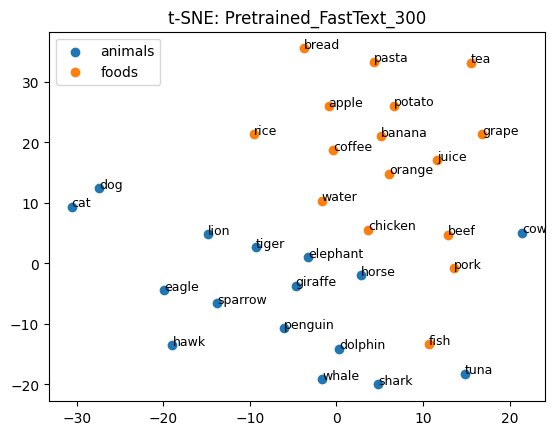

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_2d(Z, labels, groups, title):
    groups_unique = list(dict.fromkeys(groups))
    for g in groups_unique:
        idx = [i for i, gg in enumerate(groups) if gg == g]
        pts = Z[idx]
        plt.scatter(pts[:, 0], pts[:, 1], label=g)
        for i in idx:
            plt.text(Z[i, 0], Z[i, 1], labels[i], fontsize=9)
    plt.title(title)
    plt.legend()
    plt.show()

def tsne_visualize(name, vec_getter, perplexity=10, seed=42):
    X, labels, groups = collect_vectors(words_by_group, vec_getter)
    if X is None:
        print(name, "no vectors found")
        return
    tsne = TSNE(n_components=2, perplexity=min(perplexity, max(2, (len(X)-1)//3)), random_state=seed, init="pca", learning_rate="auto")
    Z = tsne.fit_transform(X)
    plot_2d(Z, labels, groups, f"t-SNE: {name}")

tsne_visualize("PyTorch_SGNS_100", sources["PyTorch_SGNS_100"])
tsne_visualize("Gensim_Text8_100", sources["Gensim_Text8_100"])
tsne_visualize("Pretrained_W2V_300", sources["Pretrained_W2V_300"])
tsne_visualize("Pretrained_FastText_300", sources["Pretrained_FastText_300"])


/Users/jeffreyzhang/.virtualenvs/r-reticulate/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


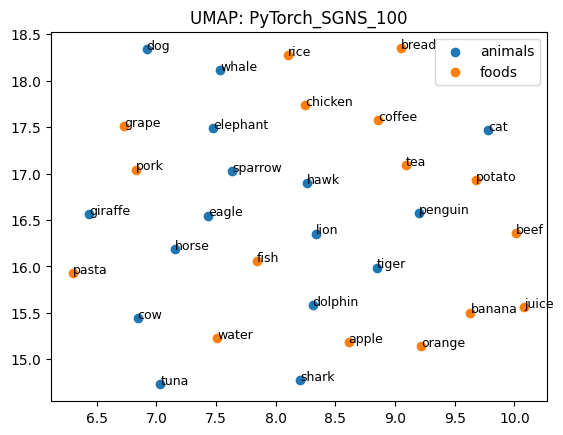

/Users/jeffreyzhang/.virtualenvs/r-reticulate/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


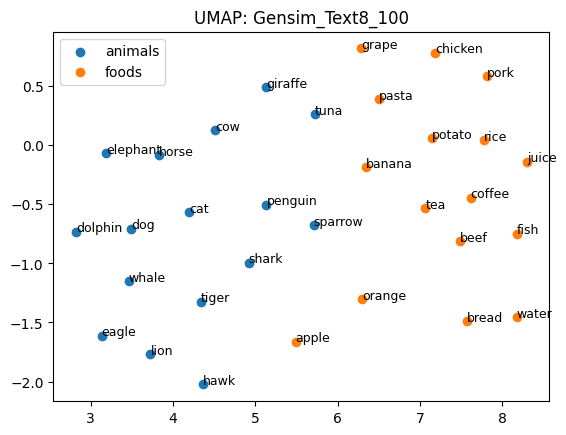

/Users/jeffreyzhang/.virtualenvs/r-reticulate/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


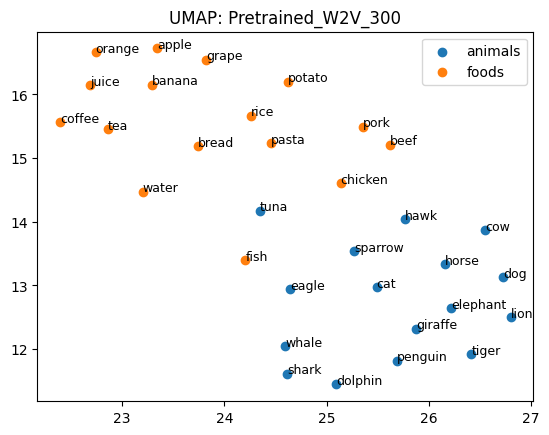

/Users/jeffreyzhang/.virtualenvs/r-reticulate/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


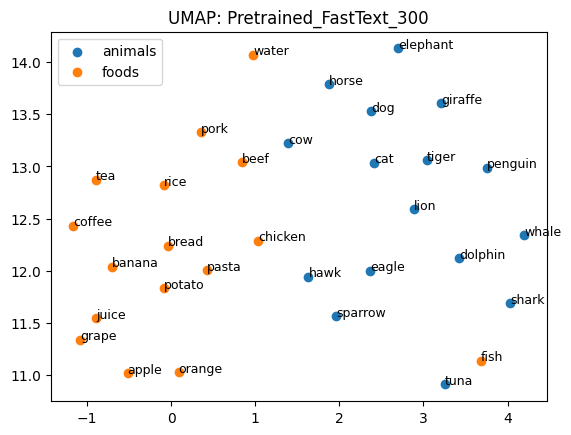

In [13]:
import importlib, sys

if importlib.util.find_spec("umap") is None:
    !pip -q install umap-learn

import umap

def umap_visualize(name, vec_getter, n_neighbors=10, min_dist=0.3, seed=42):
    X, labels, groups = collect_vectors(words_by_group, vec_getter)
    if X is None:
        print(name, "no vectors found")
        return
    reducer = umap.UMAP(n_components=2, n_neighbors=min(n_neighbors, max(2, len(X)-1)), min_dist=min_dist, random_state=seed)
    Z = reducer.fit_transform(X)
    plot_2d(Z, labels, groups, f"UMAP: {name}")

umap_visualize("PyTorch_SGNS_100", sources["PyTorch_SGNS_100"])
umap_visualize("Gensim_Text8_100", sources["Gensim_Text8_100"])
umap_visualize("Pretrained_W2V_300", sources["Pretrained_W2V_300"])
umap_visualize("Pretrained_FastText_300", sources["Pretrained_FastText_300"])


Part 7: 
(a) Pretrained_FastText_300 performed best in the cosine-similarity test: it gave the highest similarity to the two “cat/feline + carpet/rug” sentences (0.91-.92) and generally produced more consistent semantic scores across the list. Pretrained_W2V_300 was next, then Gensim_Text8_100, and PyTorch_SGNS_100 was weakest.

(b) Yes, the pretrained embeddings were significantly better. The PyTorch model only trained on Text8 with 100D vectors and relatively limited optimization/time, so it learned a coarser semantic space. The pretrained models were trained on much larger corpora and therefore encode broader semantics and richer co-occurrence statistics. FastText also benefits from subword information, improving robustness and representation quality.
Based on the visulization, my embeddings mixed animals and food together while the other three embeddings separate animals and food explicitely, except for fish which I guess in many contexts are both fish and food.

(c) Pretrained models see far more text and more varied contexts than Text8, so they capture sentence-level meaning better under mean pooling. Pretrained vectors are 300D vs mine 100D, giving more representational capacity.

## AI Use Disclosure (Required)

If you used any AI-enabled tools (e.g., ChatGPT, GitHub Copilot, Claude, or other LLM assistants) while working on this assignment, you must disclose that use here. The goal is transparency-not punishment.

In your disclosure, briefly include:
- **Tool(s) used:** (name + version if known)
- **How you used them:** (e.g., concept explanation, debugging, drafting code, rewriting text)
- **What you verified yourself:** (e.g., reran the notebook, checked outputs/plots, checked shapes, read documentation)
- **What you did *not* use AI for (if applicable):** (optional)

You are responsible for the correctness of your submission, even if AI suggested code or explanations.

#### <font color="red">Write your disclosure here.</font>


Tools used: ChatGPT 5.2 Thinking
How do you used them: check for coding syntax and help with coding structures.
What you verified yourself: reran the notebook, checked outputs/plots.